## Library Imports

In [1]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import random

## Image Matrix Construction

In [2]:
file_dict = {} # dictionary to hold path to each image (for reduced space & faster access time)

def create_vec(location, count_of_same_celebrity=40):
    '''
    Create a random vectorized array with 'n' number of images of each celebrity

    location: location of the master folder
    count_of_same_celebrity: number of random images taken of the same celebrity
    '''
    # Create an empty list to store arrays
    img_arrays = []
    global file_dict

    idx = 0

    for celeb in os.listdir(location):
        celeb_path = os.path.join(location, celeb)
        if not os.path.isdir(celeb_path):
            continue  # Skip if the item in the directory is not a folder

        files = [f for f in os.listdir(celeb_path) if os.path.isfile(os.path.join(celeb_path, f))]

        # Use min() to avoid going beyond the available indices
        selected_files = random.sample(files, min(len(files), count_of_same_celebrity))

        for selected_file in selected_files:
            face_path = os.path.join(celeb_path, selected_file)
            file_dict[idx] = face_path
            idx+=1

            # Open and resize the face image
            face_image = Image.open(face_path).convert("L")  # Convert to grayscale
            resized_face_image = face_image.resize((20, 20))
            img_array = np.array(resized_face_image).flatten()
            img_arrays.append(img_array)

    # Convert the list of arrays into a NumPy array
    img_matrix = np.transpose(img_arrays)

    return img_matrix


A = create_vec('Cropped Celebrity Faces Dataset')

In [3]:
n = A.shape[0]
m = A.shape[1]
print("n =", n)
print("m =", m)

n = 400
m = 680


In [4]:
mean = np.mean(A, axis=1, keepdims=True)
B = A - mean

In [5]:
# Covariance
S = 1/m * B @ B.T
S.shape

(400, 400)

## Zhang et al. Encryption Upon Correction

### Generation of U

In [6]:
alpha = np.random.rand()
gamma = np.random.rand()

G = np.diag(np.random.rand(n))
S1 = alpha * S + gamma * np.eye(n)
U = np.block([[S1, np.zeros((n,n))], [np.zeros((n,n)), G]])

# Multiplying orthogonal matrices
from scipy.sparse import rand
u1 = rand(2*S.shape[0], 1);
u1=u1.toarray();
u1 = u1 / np.linalg.norm(u1)
P = np.identity(2*S.shape[0]) - 2 * (u1 @ u1.T)
U1 = P @ U @ P.T

## Eigendecomposition

In [7]:
# D=Eigenvalues V=Eigenvectors  without Cheating
D , V = np.linalg.eig(U1)
D1=np.diag(D)
D1.shape

(800, 800)

## Verification

In [8]:
l=int(input('No. of trials= '))

for i in range(l):
    e = np.random.choice([0, 1], size=(V.shape[0]))
    err = np.linalg.norm(V @ (D1 @ (V.T @ e)) - U1 @ e)

    if err >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

No. of trials= 80
Verification successful for all trials


## Decryption

In [9]:
U_block = P.T @ V
U = U_block[0:S.shape[0],0:S.shape[1]]
D_block = D1[0:S.shape[0],0:S.shape[1]] - gamma * np.eye(S.shape[0])
D_new = 1/alpha * D_block
D_list = np.diag(D_new)
D_list.shape

(400,)

## Sorting eigenvectors and eigenvalues

In [10]:
sorted_indices = np.argsort(D_list)[::-1]
U_sorted = U[:, sorted_indices]
U_sorted.shape

(400, 400)

In [11]:
# Number of eigenfaces
num_components = 100
selected_U = U_sorted[:, :num_components]
selected_U.shape
# Project data onto selected eigenvectors (eigenfaces)
W = selected_U.T @ B

W.shape

(100, 680)

## Testing image

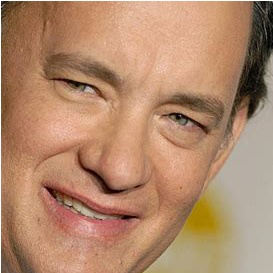

In [12]:
def preprocess_test_image(file_path, target_size=(20, 20)):
    img = Image.open(file_path).convert('L')  # Convert image to grayscale
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize image to a uniform size
    img_array = np.array(img_resized).flatten()  # Flatten the resized image to a single column vector
    return img_array

# Path to your test image file (replace with the actual path to your test image)
test_image_path = 'Test/Tom Hanks/008_74cd0628.jpg'  # Replace with your test image file path

from IPython.display import display
import matplotlib.pyplot as plt
img = Image.open(test_image_path)
display(img)

In [13]:
# Load and preprocess the test image into a column vector
x = preprocess_test_image(test_image_path)

x_reshaped = x.reshape(-1,1)
x_reshaped.shape

# Normalizing
x_norm = x_reshaped - mean
# Transforming
x_trans = selected_U.T @ x_norm

In [14]:
d = np.linalg.norm(x_trans - W, axis=0)
d_min = np.min(d)
d_index = np.argmin(d)

In [16]:
from IPython.display import display

def display_original(n):
  '''
  n: a number less than A.shape[1] and the index of the image to be displayed
  '''
  global file_dict
  display(Image.open(file_dict[n]))

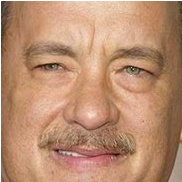

In [17]:
display_original(d_index)

# Twisted (Cheating)

In [18]:
a = np.random.randn(U1.shape[0],1)*100
b = np.square(a)
D_twisted = np.zeros_like(D)
for i in range(len(D)):
    D_twisted[i] = D[i] / b[i]
D1_twisted = np.diag(D_twisted)

V_twisted = np.zeros_like(V)
for i in range(len(a)):
    V_twisted[:, i] = V[:, i] * a[i]

V_twisted.shape

(800, 800)

## Verification

In [19]:
l=int(input('No. of trials= '))

for i in range(l):
    e1 = np.random.choice([0, 1], size=(V.shape[0]))
    err2 = np.linalg.norm(V_twisted @ (D1_twisted @ (V_twisted.T @ e1)) - U1 @ e1)

    if err2 >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

No. of trials= 80
Verification successful for all trials


## Decryption

In [20]:
U_twistedblock = P.T @ V_twisted
U_twisted = U_twistedblock[0:S.shape[0],0:S.shape[1]]
D_twistedblock = D1_twisted[0:S.shape[0],0:S.shape[1]] - gamma * np.eye(S.shape[0])
D_twistednew = 1/alpha * D_twistedblock
D_twistedlist = np.diag(D_twistednew)
D_twistedlist.shape

(400,)

## Incorrect sorting

In [21]:
twisted_indices = np.argsort(D_twistedlist)[::-1]

U_twistedsorted = U_twisted[:, twisted_indices]
U_twistedsorted.shape


(400, 400)

In [22]:
# Number of twisted eigenfaces
num_components = 100
corrupted_U = U_twistedsorted[:, :num_components]

# Project data onto selected eigenvectors (eigenfaces)
W_corrupted = corrupted_U.T @ B

In [23]:
# Twisted transformation of x
x_corrupted = corrupted_U.T @ x_norm

In [24]:
d_new = np.linalg.norm(x_corrupted - W_corrupted, axis=0)
d_newmin = np.min(d_new)
d_newindex = np.argmin(d_new)

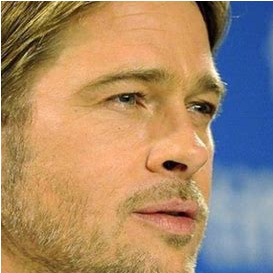

In [25]:
display_original(d_newindex)

# New Robust Verification Method 

In [26]:
l=int(input('No. of trials'))
for i in range(l):
    e2 = np.random.choice([0, 1], size=(V.shape[0]))
    err2 = np.linalg.norm(V_twisted.T @ (V_twisted @ e2) - e2)
    
    if err2 >= 1e-4:
        print("Verification failed")
        break
    
    
    e1 = np.random.choice([0, 1], size=(V.shape[0]))
    err1 = np.linalg.norm(V_twisted @ (D1_twisted @ (V_twisted.T @ e1)) - U1 @ e1)
    
    if err1 >= 1e-4:
        print("Verification failed")
        break
else:
    print("Verification successful for all trials")

No. of trials1
Verification failed
